In [14]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import ast

df = pd.read_csv('data_for_LDA.csv')
df['tokens'] = df['tokens'].apply(ast.literal_eval)

sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sia.polarity_scores(text)['compound']

df['sentiment_score'] = df['tokens'].apply(lambda x: ' '.join(x)).apply(get_sentiment_scores)


In [15]:
positive_df = df[df['sentiment_score'] >= 0.05]  
negative_df = df[df['sentiment_score'] < 0.05]

Top Positive Topics:
Topic #0: food great nt place service good time restaurant mexican like
Topic #1: tacos taco food place good nt mexican like best great
Topic #2: good ordered chips nt salsa chicken got came great delicious

Top Negative Topics:
Topic #0: food tacos nt taco ordered place chicken mexican burrito like
Topic #1: food nt service place minutes came table time bad server
Topic #2: order nt food time location place chipotle service manager people
Top Positive Topics:


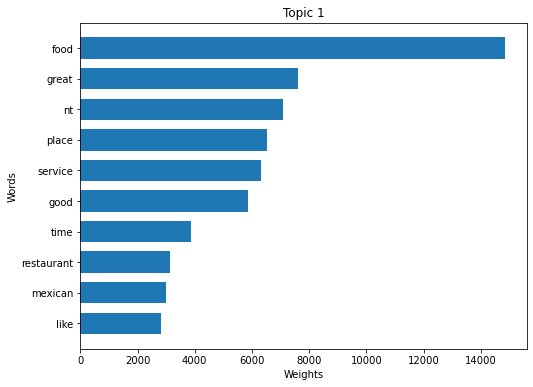

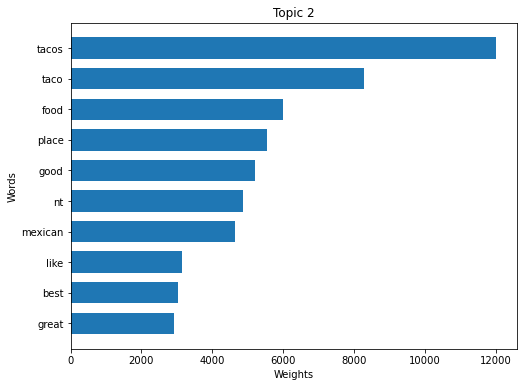

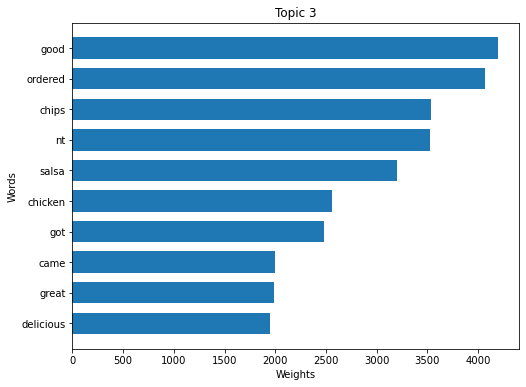


Top Negative Topics:


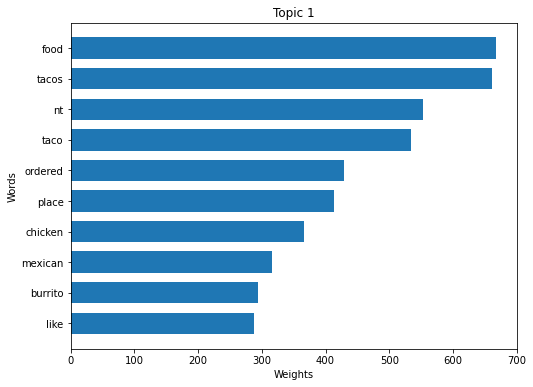

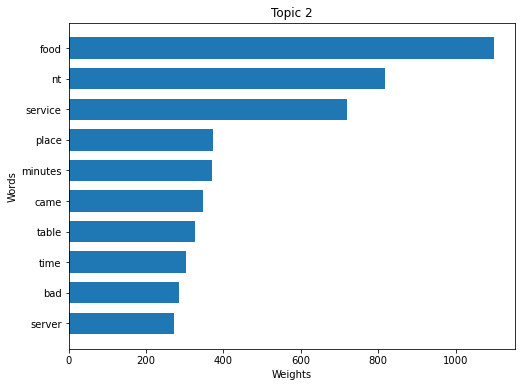

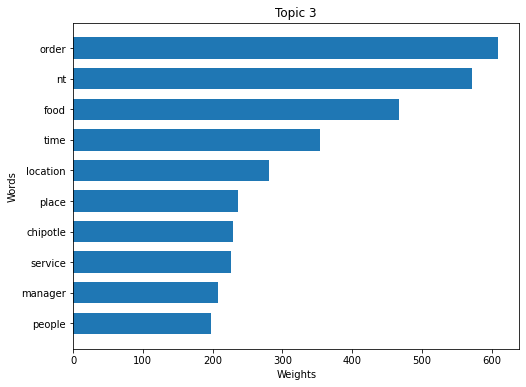

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from nltk.sentiment import SentimentIntensityAnalyzer

df = pd.read_csv('data_for_LDA.csv')
df['tokens'] = df['tokens'].apply(ast.literal_eval)

sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sia.polarity_scores(text)['compound']

df['sentiment_score'] = df['tokens'].apply(lambda x: ' '.join(x)).apply(get_sentiment_scores)

positive_df = df[df['sentiment_score'] >= 0.05]
negative_df = df[df['sentiment_score'] < 0.05]

def train_lda(data, n_topics=3):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(data['tokens'].apply(lambda x: ' '.join(x)))
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    return lda, vectorizer.get_feature_names(), dtm

def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

def plot_top_words_bar(lda_model, feature_names, n_top_words=10, n_topics=None):
    if n_topics is None:
        n_topics = lda_model.n_components
    for topic_idx in range(n_topics):
        topic = lda_model.components_[topic_idx]
        top_features_ind = topic.argsort()[-n_top_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        plt.figure(figsize=(8, 6))
        plt.barh(top_features, weights, height=0.7)
        plt.title(f'Topic {topic_idx + 1}')
        plt.xlabel('Weights')
        plt.ylabel('Words')
        plt.gca().invert_yaxis()
        plt.show()



positive_lda, positive_feature_names, positive_dtm = train_lda(positive_df, n_topics=3)
negative_lda, negative_feature_names, negative_dtm = train_lda(negative_df, n_topics=3)

print("Top Positive Topics:")
print_top_words(positive_lda, positive_feature_names)

print("\nTop Negative Topics:")
print_top_words(negative_lda, negative_feature_names)

print("Top Positive Topics:")
plot_top_words_bar(positive_lda, positive_feature_names, n_top_words=10)

print("\nTop Negative Topics:")
plot_top_words_bar(negative_lda, negative_feature_names, n_top_words=10)



In [17]:
import pandas as pd
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ast

df = pd.read_csv('data_for_LDA.csv')
df['tokens'] = df['tokens'].apply(ast.literal_eval)

sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['tokens'].apply(lambda tokens: ' '.join(tokens)).apply(lambda text: sia.polarity_scores(text)['compound'])

positive_df = df[df['sentiment_score'] >= 0.1]  
negative_df = df[df['sentiment_score'] < 0.1]  

def create_bigrams(tokens_list):
    phrases = Phrases(tokens_list, min_count=5, threshold=10)
    bigram = Phraser(phrases)
    return [' '.join(bigram[tokens]) for tokens in tokens_list]

positive_df['bigrams_str'] = create_bigrams(positive_df['tokens'].tolist())
negative_df['bigrams_str'] = create_bigrams(negative_df['tokens'].tolist())

def train_lda(data, n_topics):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(data['bigrams_str'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    return lda, vectorizer.get_feature_names()

positive_lda, positive_feature_names = train_lda(positive_df, n_topics=3)
negative_lda, negative_feature_names = train_lda(negative_df, n_topics=3)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("Positive topics:")
print_top_words(positive_lda, positive_feature_names, 10)

print("\nNegative topics:")
print_top_words(negative_lda, negative_feature_names, 10)


<ipython-input-17-35a634400fac>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['bigrams_str'] = create_bigrams(positive_df['tokens'].tolist())
<ipython-input-17-35a634400fac>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df['bigrams_str'] = create_bigrams(negative_df['tokens'].tolist())


Positive topics:
Topic #0:
nt food ordered order good place like came got table
Topic #1:
food great place service good amazing love delicious mexican restaurant
Topic #2:
tacos good taco place food chicken nt delicious fresh great

Negative topics:
Topic #0:
food nt service place location order chipotle time bad good
Topic #1:
food order nt said service table asked minutes told manager
Topic #2:
food place tacos nt ordered chicken bad good got taco


Positive Topics:


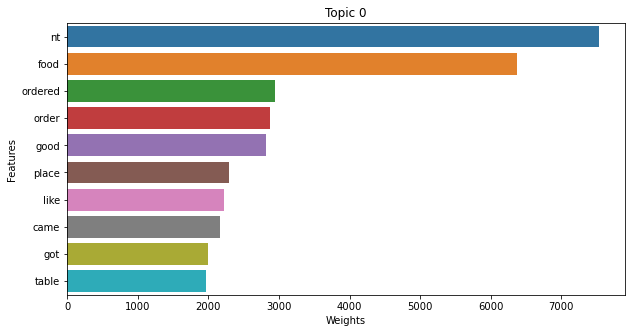

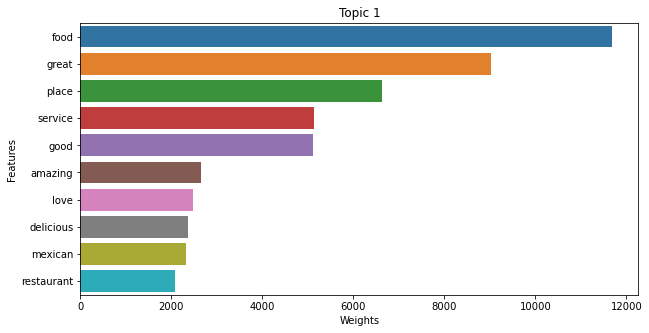

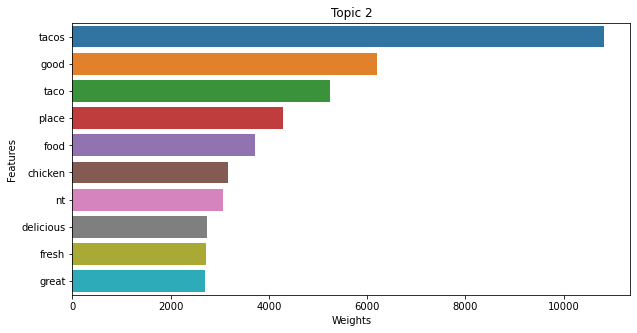


Negative Topics:


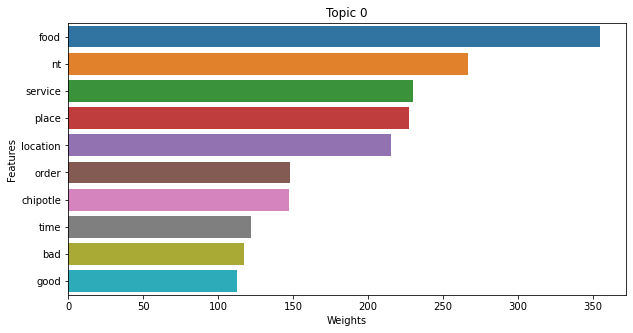

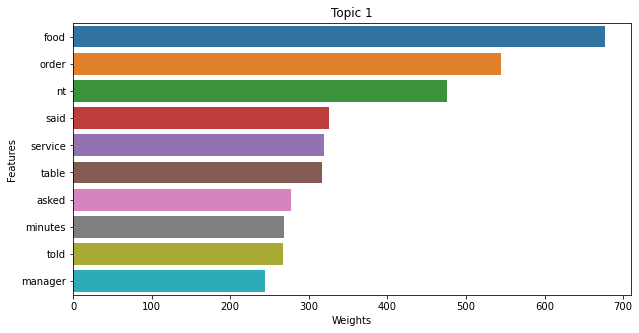

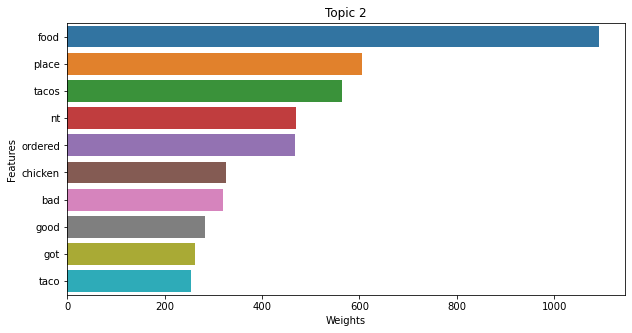

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_beta_matrix(lda_model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        plt.figure(figsize=(10, 5))
        sns.barplot(x=weights, y=top_features, orient='h')
        plt.title(f'Topic {topic_idx}')
        plt.xlabel('Weights')
        plt.ylabel('Features')
        plt.show()
        


positive_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
positive_dtm = positive_vectorizer.fit_transform(positive_df['bigrams_str'])
positive_lda = LatentDirichletAllocation(n_components=3, random_state=0)
positive_lda.fit(positive_dtm)

negative_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
negative_dtm = negative_vectorizer.fit_transform(negative_df['bigrams_str'])
negative_lda = LatentDirichletAllocation(n_components=3, random_state=0)
negative_lda.fit(negative_dtm)


print("Positive Topics:")
plot_beta_matrix(positive_lda, positive_feature_names)
print("\nNegative Topics:")
plot_beta_matrix(negative_lda, negative_feature_names)



Positive topics:
Topic #0:
food nt service place great good order time server table
Topic #1:
good nt tacos ordered food great like chicken got taco
Topic #2:
food place tacos great good love service amazing delicious best

Negative topics:
Topic #0:
food order place location nt time bad service restaurant chipotle
Topic #1:
food nt table said people asked place service got came
Topic #2:
food tacos ordered nt place taco good burrito got chicken
Top Positive Topics:


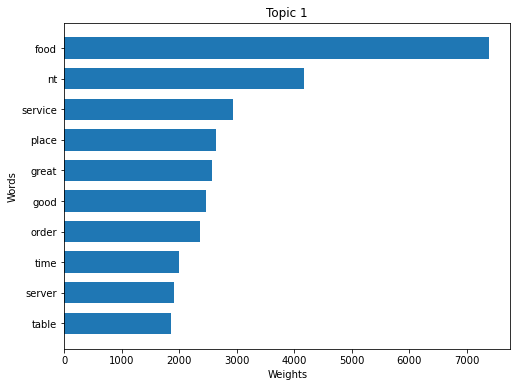

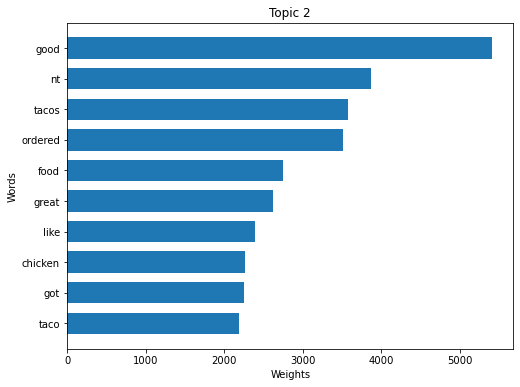

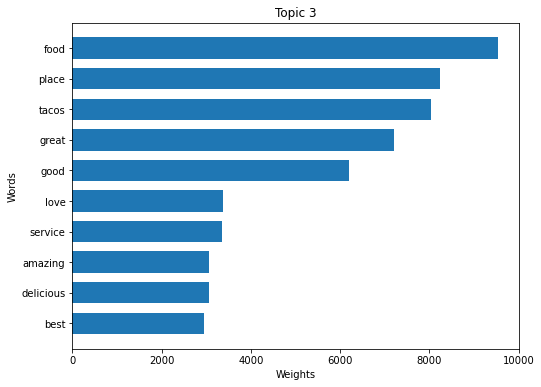


Top Negative Topics:


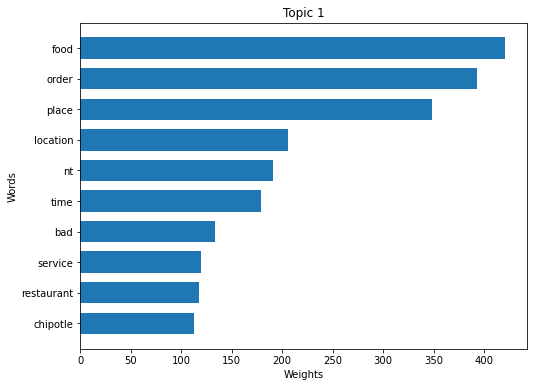

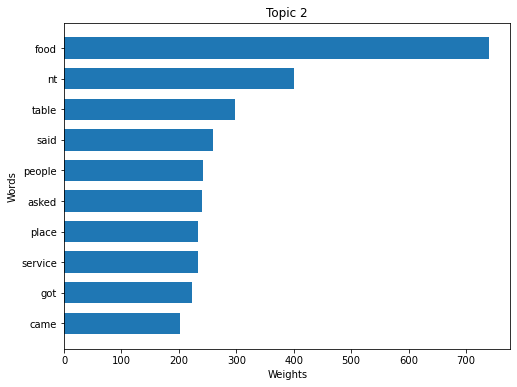

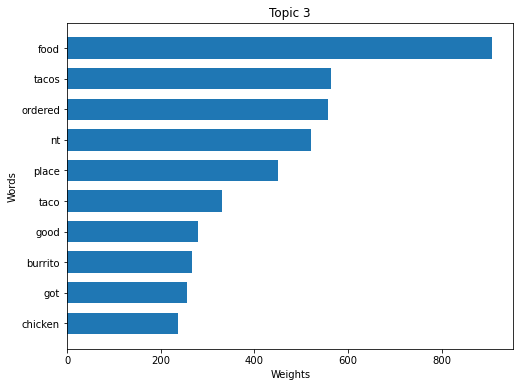

In [19]:
import pandas as pd
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ast
import matplotlib.pyplot as plt

df = pd.read_csv('data_for_LDA.csv')
df['tokens'] = df['tokens'].apply(ast.literal_eval)

sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['tokens'].apply(lambda tokens: ' '.join(tokens)).apply(lambda text: sia.polarity_scores(text)['compound'])

positive_df = df[df['sentiment_score'] >= 0.1].copy()
negative_df = df[df['sentiment_score'] < 0.1].copy()

def create_trigrams(tokens_list):
    bigram_phrases = Phrases(tokens_list, min_count=5, threshold=10)
    bigram = Phraser(bigram_phrases)
    trigram_phrases = Phrases(bigram[tokens_list], min_count=5, threshold=10)
    trigram = Phraser(trigram_phrases)
    return [' '.join(trigram[bigram[tokens]]) for tokens in tokens_list]

positive_df['trigrams_str'] = create_trigrams(positive_df['tokens'].tolist())
negative_df['trigrams_str'] = create_trigrams(negative_df['tokens'].tolist())

def train_lda(data, n_topics):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(data['trigrams_str'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    return lda, vectorizer.get_feature_names()

positive_lda, positive_feature_names = train_lda(positive_df, n_topics=3)
negative_lda, negative_feature_names = train_lda(negative_df, n_topics=3)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("Positive topics:")
print_top_words(positive_lda, positive_feature_names, 10)
print("\nNegative topics:")
print_top_words(negative_lda, negative_feature_names, 10)

def plot_top_words_bar(lda_model, feature_names, n_top_words=10, n_topics=None):
    if n_topics is None:
        n_topics = lda_model.n_components
    for topic_idx in range(n_topics):
        topic = lda_model.components_[topic_idx]
        top_features_ind = topic.argsort()[-n_top_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        plt.figure(figsize=(8, 6))
        plt.barh(top_features, weights, height=0.7)
        plt.title(f'Topic {topic_idx + 1}')
        plt.xlabel('Weights')
        plt.ylabel('Words')
        plt.gca().invert_yaxis()
        plt.show()


print("Top Positive Topics:")
plot_top_words_bar(positive_lda, positive_feature_names, n_top_words=10)

print("\nTop Negative Topics:")
plot_top_words_bar(negative_lda, negative_feature_names, n_top_words=10)


